In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/MyDrive/DlClass

/content/gdrive/MyDrive/DlClass


In [3]:
ls

1_classification/  3_yolo/                ObjectDetection-YOLO.zip  run3.mp4
2_ssd/             ObjectDetection-YOLO/  pytorch-ssd/


In [4]:
cd ObjectDetection-YOLO/

/content/gdrive/MyDrive/DlClass/ObjectDetection-YOLO


In [5]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path

# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image


0 : yolo 1: tiny

In [6]:
tiny=1

In [7]:
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
if (tiny == 1):
    modelConfiguration = "yolov3-tiny.cfg"
    modelWeights = "yolov3-tiny.weights"
    print('tiny !!!')  
else:
    modelConfiguration = "yolov3.cfg"
    modelWeights = "yolov3.weights"


tiny !!!


In [8]:
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
print('Using CPU device.')


Using CPU device.


In [9]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(frame, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(frame, classIds[i], confidences[i], left, top, left + width, top + height)


In [10]:
def frame_infer(frame):
        blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))
        # Remove the bounding boxes with low confidence
        postprocess(frame, outs)

        # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
        t, _ = net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
        cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))   
        return frame 

In [11]:
def imagefile_infer(imagename):
    if not os.path.isfile(imagename):
        print("Input image file ", imagename, " doesn't exist")
        sys.exit(1)
    print("Input image file ", imagename)
    cap = cv.VideoCapture(imagename)
    if (tiny == 1):
        outputFile = imagename[:-4]+'_yolotiny_out.jpg'
    else:
        outputFile = imagename[:-4]+'_yolo_out.jpg'

    frame = None
    hasFrame, frame = cap.read()
    if not hasFrame:
        print("no frame !!!")

    else :
        print("has frame !!!")
        # Create a 4D blob from a frame.
        blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        postprocess(frame, outs)

        # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
        t, _ = net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
        cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

        # Write the frame with the detection boxes
        cv.imwrite(outputFile, outframe.astype(np.uint8))    

    cap.release()

In [12]:
def imagefile_infer2(imagename):
    if not os.path.isfile(imagename):
        print("Input image file ", imagename, " doesn't exist")
        sys.exit(1)
    print("Input image file ", imagename)
    cap = cv.VideoCapture(imagename)
    if (tiny == 1):
        outputFile = imagename[:-4]+'_yolotiny_out.jpg'
    else:
        outputFile = imagename[:-4]+'_yolo_out.jpg'

    frame = None
    hasFrame, frame = cap.read()
    if not hasFrame:
        print("no frame !!!")

    else :
        print("has frame !!!")

        outframe = frame_infer(frame)
        print('infer success outframe')

        # Write the frame with the detection boxes
        cv.imwrite(outputFile, outframe.astype(np.uint8))    

    cap.release()


In [ ]:
imagefile_infer2('bird.jpg')

Input image file  bird.jpg
has frame !!!


In [ ]:
ls

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(9, 5)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
imShow('bird_yolo_out.jpg')

In [ ]:
imShow('bird_yolotiny_out.jpg')

In [ ]:
pwd

In [ ]:
ls run3.mp4

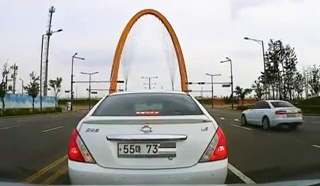

Done processing !!!


In [ ]:
import cv2
from IPython.display import display, Image
import time

path='run3.mp4'
fps = 30

cap = cv2.VideoCapture(path)
display_handle=display(None, display_id=True)
try:
    if cap.isOpened(): 
        while cap.isOpened():
            hasFrame, frame = cap.read()
    
            # Stop the program if reached end of video
            if not hasFrame:
                print("Done processing !!!")    
                cv.waitKey(3000)
                # Release device
                cap.release()
                break
            width=360
            height=224
            #resized_image = cv2.resize(frame,(width, height), interpolation = cv2.INTER_CUBIC)
            #outframe = frame_infer(resized_image)
            _, outframe = cv2.imencode('.jpeg', frame)
            display_handle.update(Image(data=outframe.tobytes()))
            #if cv2.waitKey(int(1000.0/fps)) & 0xFF == ord('q'):
                #break

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    #display_handle.update(None)

Video Inference !!!

In [ ]:
import cv2
from IPython.display import display, Image
import time

#path='accident.mp4'
path='run3.mp4'
fps = 30

cap = cv2.VideoCapture(path)
display_handle=display(None, display_id=True)
try:
    if cap.isOpened(): 
        while cap.isOpened():
            hasFrame, frame = cap.read()
    
            # Stop the program if reached end of video
            if not hasFrame:
                print("Done processing !!!")    
                cv2.waitKey(3000)
                # Release device
                cap.release()
                break
            width=360
            height=224
            #resized_image = cv2.resize(frame,(width, height), interpolation = cv2.INTER_CUBIC)
            outframe = frame_infer(frame)
            _, outframe = cv2.imencode('.jpeg', outframe)
            display_handle.update(Image(data=outframe.tobytes()))
            #if cv2.waitKey(int(1000.0/fps)) & 0xFF == ord('q'):
                #break

except KeyboardInterrupt:
    pass
finally:
    cap.release()